In [2]:
import json
import os
import rasterio as rio
import geopandas as gpd
from shapely.geometry import box
from fiona.crs import from_epsg
from rasterio.mask import mask
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.insert(0, '/projects/pygeotools')
from pygeotools.lib import filtlib, iolib, malib, warplib

from osgeo import gdal


ImportError: this version of pandas is incompatible with numpy < 1.16.5
your numpy version is 1.15.4.
Please upgrade numpy to >= 1.16.5 to use this pandas version

In [5]:
## open json
## parses json file and returns local filepaths
## outputs a listof the local filepaths
def GetBandLists(inJSON, bandnum):
    with open(inJSON) as f:
        response = json.load(f)
    
    BandList = []
    for i in range(len(response.keys())):
        try:
            getBand = response['features'][i]['assets']['SR_B' + str(bandnum) + '.TIF']['href']
            BandList.append(getBand)
        except exception as e:
            print(e)
        
    return BandList


BLUEBands = GetBandLists('/projects/alexdevseed/landsat8/local-2018.json', 2)
GREENBands = GetBandLists('/projects/alexdevseed/landsat8/local-2018.json', 3)
REDBands = GetBandLists('/projects/alexdevseed/landsat8/local-2018.json', 4)
NIRBands = GetBandLists('/projects/alexdevseed/landsat8/local-2018.json', 5)
SWIRBands = GetBandLists('/projects/alexdevseed/landsat8/local-2018.json', 6)

print("file locations of red bands over ROI = ", REDBands)
print("file locations of nir bands over ROI = ", NIRBands)


file locations of red bands over ROI =  ['/projects/alexdevseed/landsat8/LC08_L2SP_031029_20180910_20200830_02_T1/LC08_L2SP_031029_20180910_20200830_02_T1_SR_B4.TIF', '/projects/alexdevseed/landsat8/LC08_L2SP_031028_20180910_20200830_02_T1/LC08_L2SP_031028_20180910_20200830_02_T1_SR_B4.TIF', '/projects/alexdevseed/landsat8/LC08_L2SP_031029_20180825_20200831_02_T1/LC08_L2SP_031029_20180825_20200831_02_T1_SR_B4.TIF', '/projects/alexdevseed/landsat8/LC08_L2SP_032028_20180816_20200831_02_T1/LC08_L2SP_032028_20180816_20200831_02_T1_SR_B4.TIF']
file locations of nir bands over ROI =  ['/projects/alexdevseed/landsat8/LC08_L2SP_031029_20180910_20200830_02_T1/LC08_L2SP_031029_20180910_20200830_02_T1_SR_B5.TIF', '/projects/alexdevseed/landsat8/LC08_L2SP_031028_20180910_20200830_02_T1/LC08_L2SP_031028_20180910_20200830_02_T1_SR_B5.TIF', '/projects/alexdevseed/landsat8/LC08_L2SP_031029_20180825_20200831_02_T1/LC08_L2SP_031029_20180825_20200831_02_T1_SR_B5.TIF', '/projects/alexdevseed/landsat8/LC08

In [6]:
## WRITE TMP FILES TO DISK.ONLY DO ONCE. 
## FILES ARE IN: '/projects/bobafett/LandsatComposites/'

## Use pygeotools to warp them all to the same extent
## inputs the list of files from above
## output is a new list of warped objects the size of the entire extent

#def WarpRasters(filelist):
#    #outWarp = warplib.memwarp_multi_fn(filelist, extent='union', res=30, t_srs='first', r='near')
#    outWarp = warplib.diskwarp_multi_fn(filelist, outdir='/projects/bobafett/LandsatComposites/', extent='union', res=30, t_srs='first', r='near')
#    return outWarp

#print("Warping rasters to same res/extent/proj")
#B_list = WarpRasters(BLUEBands)
#G_list = WarpRasters(GREENBands)
#R_list = WarpRasters(REDBands)
#NIR_list = WarpRasters(NIRBands)
#SWIR_list = WarpRasters(SWIRBands)


#print("finished")

# Get geotransform variable for later use
#GeoTForm = R_list[0].GetGeoTransform()



In [7]:
## read all bandas as masked arrays
## read each object in each list as a masked array 

def MaskArrays(file):
    print(file)
    with rio.open(file, 'r') as f:
        band = f.read(1, masked=True)
    return band.astype(float)

#Blue_band_stack = MaskArrays(B_list)
#Green_band_stack = MaskArrays(G_list)
#Red_band_stack = MaskArrays(R_list)
#NIR_band_stack = MaskArrays(NIR_list)
#SWIR_band_stack = MaskArrays(SWIR_list)

outDir = '/projects/bobafett/LandsatComposites/'

def GetFiles(file, outDir):
    base = os.path.basename(file).replace('.TIF','_warp.tif')
    outfile = os.path.join(outDir, base)
    
    return outfile
    
    
    
redFiles = [GetFiles(x, outDir) for x in REDBands]
NIRFiles = [GetFiles(x, outDir) for x in NIRBands]

print(redFiles)

#MaskedRedFiles = [MaskArrays(x) for x in redFiles]
#MaskedNIRFiles = [MaskArrays(x) for x in NIRFiles]

print("finished")

#Red_band_stack = np.ma.array([MaskArrays(x) for x in R_list]).astype(np.float)


['/projects/bobafett/LandsatComposites/LC08_L2SP_031029_20180910_20200830_02_T1_SR_B4_warp.tif', '/projects/bobafett/LandsatComposites/LC08_L2SP_031028_20180910_20200830_02_T1_SR_B4_warp.tif', '/projects/bobafett/LandsatComposites/LC08_L2SP_031029_20180825_20200831_02_T1_SR_B4_warp.tif', '/projects/bobafett/LandsatComposites/LC08_L2SP_032028_20180816_20200831_02_T1_SR_B4_warp.tif']
finished


In [ ]:
## create NDVI layers
## Loopsover lists of bands and calculates NDVI
## creates a new list of NDVI images, one per input scene

def CreateNDVIstack(REDarr, NIRarr):
    NDVIarr = []
    for i in range(np.shape(REDarr)[0]):
        print("Creating NDVI layer " + str(i+1))
        NDVIarr.append((NIRarr[i]-REDarr[i])/(NIRarr[i]+REDarr[i]))

    return np.array(NDVIarr)
        
#NDVIstack = CreateNDVIstack(MaskedRedFiles, MaskedNIRFiles)


def CreateNDVIstack2(REDfile, NIRfile):
    print("Creating NDVI layer ")
    NIRarr = MaskArrays(NIRfile)
    REDarr = MaskArrays(REDfile) 
    return (NIRarr-REDarr)/(NIRarr+REDarr)

redFiles = [redFiles[0],redFiles[2]]
NIRFiles = [NIRFiles[0],NIRFiles[2]]

NDVIstack = [CreateNDVIstack2(redFiles[i],NIRFiles[i]) for i in range(len(redFiles))] 
print('finished')


Creating NDVI layer 
/projects/bobafett/LandsatComposites/LC08_L2SP_031029_20180910_20200830_02_T1_SR_B5_warp.tif
/projects/bobafett/LandsatComposites/LC08_L2SP_031029_20180910_20200830_02_T1_SR_B4_warp.tif


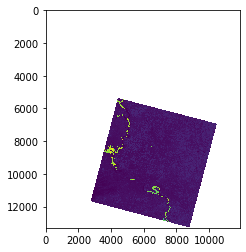

In [5]:

        
plt.show(NDVIstack[0])
plt.show(NDVIstack[1])


In [ ]:
print(np.min(NDVIstack))
print(np.max(NDVIstack))

In [ ]:
def CreateNDMIstack(SWIRarr, NIRarr):
    NDMIarr = []
    for i in range(np.shape(SWIRarr)[0]):
        print("Creating NDMI layer " + str(i+1))
        NDMIarr.append((NIRarr[i]-SWIRarr[i])/(NIRarr[i]+SWIRarr[i]))

    return np.array(NDMIarr)
        
NDMIstack = CreateNDMIstack(SWIR_band_stack, NIR_band_stack)
print('finished')

In [ ]:
print(np.min(NDMIstack))
print(np.max(NDMIstack))

In [ ]:
## get the index positions of the max NDVI value
## Get the argmax index positions from the stack of NDVI images

#Avoid slice of all nan
#NDVIstack[NDVIstack==np.nan] = 0

NDVImax = np.nanargmax(NDVIstack,axis=0)

## create a tmp array (binary mask) of the same input shape
NDVItmp = np.zeros(Red_band_stack.shape, dtype=bool)

## for each dimension assign the index position (flattens the array to a LUT)
for i in range(np.shape(Red_band_stack)[0]):
    NDVItmp[i,:,:]=NDVImax==i
    

plt.imshow(NDVImax, cmap='viridis')
plt.title("Index location of maximum NDVI value")
cbar1 = plt.colorbar()
cbar1.ax.set_ylabel(r"$\bf{Image Location}$",  labelpad=10, rotation=90)  
plt.savefig('/projects/bobafett/LandsatComposites/Landsat_MaxNDVIIdx.png', format='PNG')

In [ ]:
## Return Red value based on NDVI max index position

# insert the bands as arrays (made earlier)
## creates a single layer by using the binary mask
## and a sum function to collapse n-dims to 2-dims
def CollapseBands(inArr, NDVItmp):
    inArr[np.logical_not(NDVItmp)]=0 
    compImg = inArr.sum(0)
    
    return compImg
    

BlueComp=CollapseBands(Blue_band_stack, NDVItmp)
GreenComp=CollapseBands(Green_band_stack, NDVItmp)
RedComp=CollapseBands(Red_band_stack, NDVItmp)
NIRComp=CollapseBands(NIR_band_stack, NDVItmp)
SWIRComp=CollapseBands(SWIR_band_stack, NDVItmp)
print(np.shape(BlueComp))

In [ ]:
def norm(band):
    band_min, band_max = band.min(), band.max()
    return ((band - band_min)/(band_max - band_min))


b2 = norm(BlueComp)
b3 = norm(GreenComp)
b4 = norm(RedComp)

rgb = np.dstack((b4,b3,b2))
del b2, b3, b4

plt.imshow(rgb, vmin=np.percentile(rgb,20), vmax=np.percentile(rgb,50))
cbar1.ax.set_ylabel(r"$\bf{Reflectance}$",  labelpad=10, rotation=90)  
plt.savefig('/projects/bobafett/LandsatComposites/Landsat_RGBComposite.png', format='PNG')

In [ ]:
# Check Geotranform of all bands
print(B_list[0].GetGeoTransform())
print(G_list[0].GetGeoTransform())
print(R_list[0].GetGeoTransform())
print(NIR_list[0].GetGeoTransform())
print(SWIR_list[0].GetGeoTransform())

In [ ]:
## Create Indices of interest from new composites

print("calculating NDVI...")
NDVIComp = ((NIRComp - RedComp)/(NIRComp + RedComp))*10000
print("calculating SAVI...")
SAVIComp = (((NIRComp - RedComp)/(NIRComp + RedComp +0.5))*1.5)*10000
print("calculating Red edge (Simple ratio)...")
REComp = NIRComp - RedComp
print("calculating EVI...")
EVIComp = (2.5 * ((NIRComp - RedComp) / (NIRComp + 6 * RedComp - 7.5 * BlueComp + 1)))*10000
print("calculating NDMI...")
NDMIComp = ((NIRComp - SWIRComp) / (NIRComp + SWIRComp))*10000
print("complete")

In [ ]:
## Stack bands to write out RGB
ReflectanceStack = np.array([BlueComp, GreenComp, RedComp, NIRComp, SWIRComp])
IndicesStack = np.array([NDVIComp, SAVIComp, REComp, EVIComp, NDMIComp])
print(np.min(NDVIComp))
print(np.max(NDVIComp))

In [ ]:
# Write arrays to multiband image

from osgeo import gdal, osr
import os
import io
import numpy as np

def array2raster(newRasterfn,rasterOrigin,pixelWidth,pixelHeight,array,driver,outtype, names):

    bands = array.shape[0]
    print('number of bands: ', bands)
    rows = array.shape[1]
    cols = array.shape[2]
    originX = rasterOrigin[0]
    originY = rasterOrigin[1]
    driver = gdal.GetDriverByName(driver)
    #Here is where I assign three bands to the raster with int 3
    option=['COMPRESS=LZW']
    outRaster = driver.Create(newRasterfn, cols, rows, bands, outtype, options=option)
    outRaster.SetGeoTransform((originX, pixelWidth, 0, originY, 0, pixelHeight))
    #outband = outRaster.GetRasterBand(1)
    #outband.WriteArray(array)
    for band in range(bands):
        print("Processing band :", names[band])
        outRaster.SetDescription(names[band])
        outRaster.GetRasterBand(band+1).WriteArray( array[band, :, :] )

    outRasterSRS = osr.SpatialReference()
    outRasterSRS.ImportFromEPSG(4326)
    print('Assign spatial ref')
    outRaster.SetProjection(outRasterSRS.ExportToWkt())
    print('writing out')
    outRaster.FlushCache()
    print('complete')
    
    return outRaster

ReflectanceOutput = "/projects/bobafett/LandsatComposites/LS8_GC_2018_refl.tif"
IndicesOutput = "/projects/bobafett/LandsatComposites/LS8_GC_2018_idx.tif"

geotransform = B_list[0].GetGeoTransform()
rasterOrigin=[geotransform[0], geotransform[3]]
pixelW = geotransform[1]
pixelH = geotransform[5]

#outRaster = array2raster(ReflectanceOutput,rasterOrigin, pixelW, pixelH, ReflectanceStack, 'GTiff', gdal.GDT_UInt16, ['Blue', 'Green', 'Red', 'NIR', 'SWIR'])
outRaster = array2raster(IndicesOutput,rasterOrigin, pixelW, pixelH, IndicesStack, 'GTiff', gdal.GDT_Int16, ['NDVI', 'SAVI', "RedEdge", "EVI", "NDMI"])
print('finished')

In [ ]:

print(np.min(NDVIstack))
print(np.percentile(NDVIstack,99))

# plot the NDVI bands
plt.imshow(NDMIstack[1], cmap='viridis', norm=plt.Normalize(vmin=-0.2, vmax=0.6))
#plt.imshow(NDMIstack[2], cmap='viridis', norm=plt.Normalize(vmin=-0.2, vmax=0.6))
#plt.imshow(NDMIstack[3], cmap='viridis', norm=plt.Normalize(vmin=-0.2, vmax=0.6))
plt.title("NDMI Bands")
cbar1 = plt.colorbar()
cbar1.ax.set_ylabel(r"$\bf{NDVI}$",  labelpad=10, rotation=90)  
plt.savefig('/projects/bobafett/LandsatComposites/Landsat_NDMImosaic.png', format='PNG')

'''
# plot individual color bands
BlueCompImg = np.ma.masked_equal(BlueComp, 0)
plt.imshow(BlueCompImg, cmap='Blues', norm=plt.Normalize(vmin=4000, vmax=10000))
plt.title("Blue Band Composite")
cbar1 = plt.colorbar()
cbar1.ax.set_ylabel(r"$\bf{Blue Reflectance (x10000)}$",  labelpad=10, rotation=90)  
plt.savefig('/projects/bobafett/LandsatComposites/Landsat_BlueComposite.png', format='PNG')
plt.clf()

GreenCompImg = np.ma.masked_equal(GreenComp, 0)
plt.imshow(GreenCompImg, cmap='Greens', norm=plt.Normalize(vmin=4000, vmax=10000))
plt.title("Green Band Composite")
cbar1 = plt.colorbar()
cbar1.ax.set_ylabel(r"$\bf{Green Reflectance (x10000)}$",  labelpad=10, rotation=90)  
plt.savefig('/projects/bobafett/LandsatComposites/Landsat_GreenComposite.png', format='PNG')
plt.clf()

RedCompImg = np.ma.masked_equal(RedComp, 0)
plt.imshow(RedCompImg, cmap='Reds', norm=plt.Normalize(vmin=4000, vmax=10000))
plt.title("Red Band Composite")
cbar1 = plt.colorbar()
cbar1.ax.set_ylabel(r"$\bf{Red Reflectance (x10000)}$",  labelpad=10, rotation=90)  
plt.savefig('/projects/bobafett/LandsatComposites/Landsat_RedComposite.png', format='PNG')
plt.clf()

## plot the transformations
NDVIComp_vis = NDVIComp
NDVIComp_vis[NDVIComp_vis>1] = 0
plt.imshow(NDVIComp, cmap='viridis', norm=plt.Normalize(vmin=-0.2, vmax=0.6))
plt.title("NDVI Composite Image")
cbar1 = plt.colorbar()
cbar1.ax.set_ylabel(r"$\bf{NDVI}$",  labelpad=10, rotation=90)  
plt.savefig('/projects/bobafett/LandsatComposites/Landsat_NDVI_composite.png', format='PNG')
plt.clf()

print(np.min(SAVIComp))
print(np.max(SAVIComp))
SAVIComp_vis = SAVIComp
plt.imshow(SAVIComp, cmap='viridis', norm=plt.Normalize(vmin=-0.2, vmax=1))
plt.title("SAVI Composite Image")
cbar1 = plt.colorbar()
cbar1.ax.set_ylabel(r"$\bf{SAVI}$",  labelpad=10, rotation=90)  
plt.savefig('/projects/bobafett/LandsatComposites/Landsat_SAVI_composite.png', format='PNG')
plt.clf()

#NDMIComp_vis = NDMIComp
#NDMIComp_vis[NDMIComp_vis==0] = 0
#NDMIComp_vis[NDMIComp_vis>1] = 0
#print(np.percentile(NDMIComp,90))
#print(np.amin(NDMIComp))
#plt.imshow(NDMIComp, cmap='viridis', norm=plt.Normalize(vmin=-0.5, vmax=5))
#plt.title("NDMI Composite Image")
#cbar1 = plt.colorbar()
#cbar1.ax.set_ylabel(r"$\bf{NDMI}$",  labelpad=10, rotation=90)  
#plt.savefig('/projects/bobafett/LandsatComposites/Landsat_NDMI_composite.png', format='PNG')
#plt.clf()
'''

In [ ]:
## OLD CODE

## read json

#with open('/projects/alexdevseed/landsat8/local-2020.json') as f:
#    response = json.load(f)

## Collate Blue bands
#BLUEBands = []
#for i in range(len(response.keys())):
#    BLUEBands.append(response['features'][0]['assets']['SR_B2.TIF']['href'])

## Get list of GDALobjects
#B_list = warplib.memwarp_multi_fn(BLUEBands, extent='union', res=30, t_srs='first', r='cubic')

## For each GDAL object get masked array
#Blue1 = iolib.ds_getma(B_list[0])
#Blue2 = iolib.ds_getma(B_list[1])
#Blue3 = iolib.ds_getma(B_list[2])
#Blue4 = iolib.ds_getma(B_list[3])

#Green1 = iolib.ds_getma(G_list[0])
#Green2 = iolib.ds_getma(G_list[1])
#Green3 = iolib.ds_getma(G_list[2])
#Green4 = iolib.ds_getma(G_list[3])

#Red1 = iolib.ds_getma(R_list[0])
#Red2 = iolib.ds_getma(R_list[1])
#Red3 = iolib.ds_getma(R_list[2])
#Red4 = iolib.ds_getma(R_list[3])

#NIR1 = iolib.ds_getma(NIR_list[0])
#NIR2 = iolib.ds_getma(NIR_list[1])
#NIR3 = iolib.ds_getma(NIR_list[2])
#NIR4 = iolib.ds_getma(NIR_list[3])

#SWIR1 = iolib.ds_getma(SWIR_list[0])
#SWIR2 = iolib.ds_getma(SWIR_list[1])
#SWIR3 = iolib.ds_getma(SWIR_list[2])
#SWIR4 = iolib.ds_getma(SWIR_list[3])


## create NDVI layers

#NDVI1 = (NIR1-Red1)/(NIR1+Red1)
#NDVI2 = (NIR2-Red2)/(NIR2+Red2)
#NDVI3 = (NIR3-Red3)/(NIR3+Red3)
#NDVI4 = (NIR4-Red4)/(NIR4+Red4)

## stack the individual bands together

#BlueStack = np.ma.array([Blue1, Blue2, Blue3, Blue4])
#GreenStack = np.ma.array([Green1, Green2, Green3, Green4])
#RedStack = np.ma.array([Red1, Red2, Red3, Red4])
#NIRStack = np.ma.array([NIR1, NIR2, NIR3, NIR4])
#SWIRStack = np.ma.array([SWIR1, SWIR2, SWIR3, SWIR4])

## get the index positions of the max NDVI value

#NDVImax = np.nanargmax((NDVI1,NDVI2,NDVI3,NDVI4),axis=0)

#NDVItmp = np.zeros(RedStack.shape, dtype=bool)

#for i in range(np.shape(RedStack)[0]):
#    NDVItmp[i,:,:]=NDVImax==i


## Return Red value based on NDVI max index position

#RedComposite[NDVItmp] = RedStack[NDVItmp]
#BlueStack[np.logical_not(NDVItmp)]=0
#BlueComp=BlueStack.sum(0)

#GreenStack[np.logical_not(NDVItmp)]=0
#GreenComp=GreenStack.sum(0)

#RedStack[np.logical_not(NDVItmp)]=0
#RedComp=RedStack.sum(0)

#NIRStack[np.logical_not(NDVItmp)]=0
#NIRComp=NIRStack.sum(0)

#SWIRStack[np.logical_not(NDVItmp)]=0
#SWIRComp=SWIRStack.sum(0)

## Ends up with Composite Images